In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#______________________________________Imports_______________________________________
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from PIL import Image

# --------------------------------------------------
# Step 1: Define Paths for Image and Label Data
# --------------------------------------------------
    
training_images_directory ='/kaggle/input/soil-classification-part-2/soil_competition-2025/train'
test_images_directory = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test'
training_labels_csv_path = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv'
test_ids_csv_path = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv'

# --------------------------------------------------
# Step 2: Load Training Labels into a DataFrame
# --------------------------------------------------
labels_dataframe = pd.read_csv(training_labels_csv_path)

# --------------------------------------------------
# Step 3: Perform Stratified Train-Validation Split
# --------------------------------------------------
training_dataframe, validation_dataframe = train_test_split(
    labels_dataframe,
    test_size=0.2,
    stratify=labels_dataframe['label'],
    random_state=42
)

# --------------------------------------------------
# Step 4: Define Image Transformation Pipeline
# --------------------------------------------------
image_transformation_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# --------------------------------------------------
# Step 5: Create Custom Dataset Class for Training and Validation
# --------------------------------------------------
class SoilImageDataset(Dataset):
    def __init__(self, dataframe, image_directory, transform=None):
        self.dataframe = dataframe
        self.image_directory = image_directory
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_filename = self.dataframe.iloc[index]['image_id']
        image_label = int(self.dataframe.iloc[index]['label'])
        full_image_path = os.path.join(self.image_directory, image_filename)
        image = Image.open(full_image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_label

# --------------------------------------------------
# Step 6: Instantiate Dataset and DataLoader for Training and Validation
# --------------------------------------------------
training_dataset = SoilImageDataset(training_dataframe, training_images_directory, image_transformation_pipeline)
validation_dataset = SoilImageDataset(validation_dataframe, training_images_directory, image_transformation_pipeline)

training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

# --------------------------------------------------
# Step 7: Define Device for Computation (GPU if Available)
# --------------------------------------------------
computation_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --------------------------------------------------
# Step 8: Load Pretrained ResNet18 Model and Modify for Binary Classification
# --------------------------------------------------
binary_classification_model = models.resnet18(pretrained=True)
binary_classification_model.fc = nn.Sequential(
    nn.Linear(binary_classification_model.fc.in_features, 1),
    nn.Sigmoid()
)
binary_classification_model = binary_classification_model.to(computation_device)

# --------------------------------------------------
# Step 9: Define Loss Function and Optimizer
# --------------------------------------------------
binary_loss_function = nn.BCELoss()
adam_optimizer = optim.Adam(binary_classification_model.parameters(), lr=1e-4)

# --------------------------------------------------
# Step 10: Define Training Function with Validation Evaluation
# --------------------------------------------------
def train_soil_model(model, train_loader, val_loader, total_epochs=10):
    for epoch in range(total_epochs):
        model.train()
        cumulative_training_loss = 0.0

        # Training Loop
        for batch_images, batch_labels in train_loader:
            batch_images = batch_images.to(computation_device)
            batch_labels = batch_labels.float().unsqueeze(1).to(computation_device)

            adam_optimizer.zero_grad()
            output_probabilities = model(batch_images)
            batch_loss = binary_loss_function(output_probabilities, batch_labels)
            batch_loss.backward()
            adam_optimizer.step()

            cumulative_training_loss += batch_loss.item()

        # Validation Loop
        model.eval()
        validation_predictions = []
        validation_targets = []

        with torch.no_grad():
            for batch_images, batch_labels in val_loader:
                batch_images = batch_images.to(computation_device)
                batch_labels = batch_labels.to(computation_device)
                output_probabilities = model(batch_images)
                predicted_labels = (output_probabilities > 0.5).int().cpu().numpy()
                validation_predictions.extend(predicted_labels.flatten())
                validation_targets.extend(batch_labels.cpu().numpy())

        validation_f1 = f1_score(validation_targets, validation_predictions)
        print(f"Epoch {epoch+1}/{total_epochs}, Training Loss: {cumulative_training_loss:.4f}, Validation F1 Score: {validation_f1:.4f}")

# --------------------------------------------------
# Step 11: Train the Model
# --------------------------------------------------
train_soil_model(binary_classification_model, training_dataloader, validation_dataloader, total_epochs=10)

# --------------------------------------------------
# Step 12: Load Test Image IDs
# --------------------------------------------------
test_image_ids_dataframe = pd.read_csv(test_ids_csv_path)

# --------------------------------------------------
# Step 13: Create Custom Dataset Class for Test Data
# --------------------------------------------------
class SoilTestImageDataset(Dataset):
    def __init__(self, dataframe, image_directory, transform=None):
        self.dataframe = dataframe
        self.image_directory = image_directory
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_filename = self.dataframe.iloc[index]['image_id']
        full_image_path = os.path.join(self.image_directory, image_filename)
        image = Image.open(full_image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, image_filename

# --------------------------------------------------
# Step 14: Instantiate Dataset and DataLoader for Test Data
# --------------------------------------------------
test_dataset = SoilTestImageDataset(test_image_ids_dataframe, test_images_directory, image_transformation_pipeline)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --------------------------------------------------
# Step 15: Generate Predictions on Test Data
# --------------------------------------------------
binary_classification_model.eval()
test_predictions = []

with torch.no_grad():
    for batch_images, image_names in test_dataloader:
        batch_images = batch_images.to(computation_device)
        output_probabilities = binary_classification_model(batch_images)
        predicted_labels = (output_probabilities > 0.5).int().cpu().numpy().flatten()
        for image_name, predicted_label in zip(image_names, predicted_labels):
            test_predictions.append({'image_id': image_name, 'label': predicted_label})

# --------------------------------------------------
# Step 16: Create Submission File and Save to Disk
# --------------------------------------------------
submission_dataframe = pd.DataFrame(test_predictions)
submission_dataframe.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


Epoch 1/10, Training Loss: 8.0836, Validation F1 Score: 0.9597
Epoch 2/10, Training Loss: 1.3351, Validation F1 Score: 1.0000
Epoch 3/10, Training Loss: 0.7120, Validation F1 Score: 1.0000
Epoch 4/10, Training Loss: 0.4389, Validation F1 Score: 1.0000
Epoch 5/10, Training Loss: 0.3365, Validation F1 Score: 1.0000
Epoch 6/10, Training Loss: 0.2537, Validation F1 Score: 1.0000
Epoch 7/10, Training Loss: 0.2382, Validation F1 Score: 1.0000
Epoch 8/10, Training Loss: 0.1856, Validation F1 Score: 1.0000
Epoch 9/10, Training Loss: 0.1281, Validation F1 Score: 1.0000
Epoch 10/10, Training Loss: 0.1146, Validation F1 Score: 1.0000
Submission file saved as 'submission.csv'


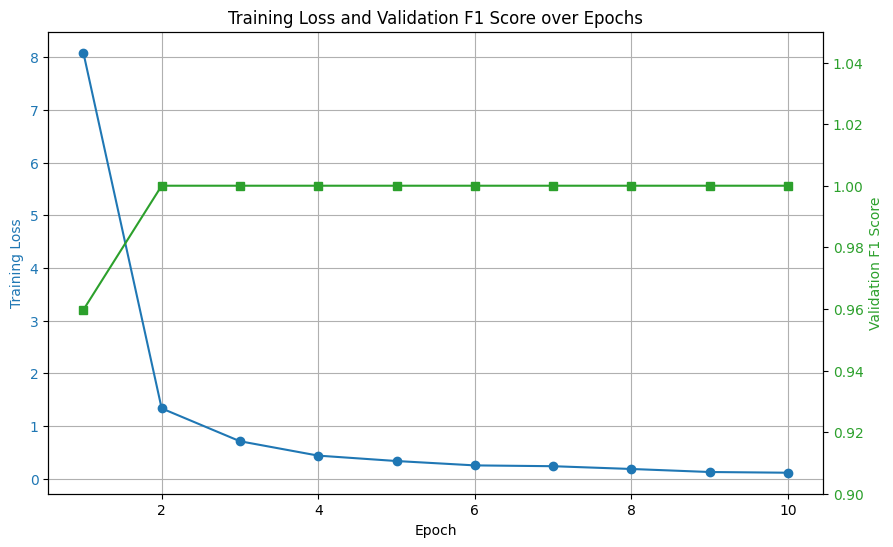

In [1]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
training_loss = [8.0836, 1.3351, 0.7120, 0.4389, 0.3365, 0.2537, 0.2382, 0.1856, 0.1281, 0.1146]
validation_f1 = [0.9597, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training loss
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(epochs, training_loss, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Plot validation F1 score using a secondary y-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Validation F1 Score', color=color)
ax2.plot(epochs, validation_f1, color=color, marker='s')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0.9, 1.05])

plt.title('Training Loss and Validation F1 Score over Epochs')
plt.show()
